# Análisis y predicción de series temporales con ARMA, SARIMA.. 

Fuente del codigo: https://github.com/ashishpatel26/

## Importación de librerías para la previsión de series de tiempo

In [1]:
#!pip install pmdarima

In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

import pandas as pd

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX


from math import sqrt

import matplotlib
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

# Importando datos
- Conjunto de datos: pasajeros de aerolíneas internacionales
- Unidad: Miles

In [3]:
df = pd.read_csv('data/international-airline-passengers.csv',header=None)

In [4]:
df.columns = ['year','passengers']

In [5]:
df.head()

,year,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [6]:
df.describe()

,passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [7]:
print('Time period start: {}\nTime period end: {}'.format(df.year.min(),df.year.max()))

Time period start: 1949-01
Time period end: 1960-12


In [8]:
df.columns

Index(['year', 'passengers'], dtype='object')

In [9]:
df.shape

(144, 2)

# Preprocesamiento y visualización de datos

__Converting to datetime format:__

In [10]:
df['year'] = pd.to_datetime(df['year'], format='%Y-%m')

__Setting index as the datetime column for easier manipulations:__

In [11]:
y = df.set_index('year')

In [12]:
y.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='year', length=144, freq=None)

In [13]:
y.isnull().sum()

passengers    0
dtype: int64

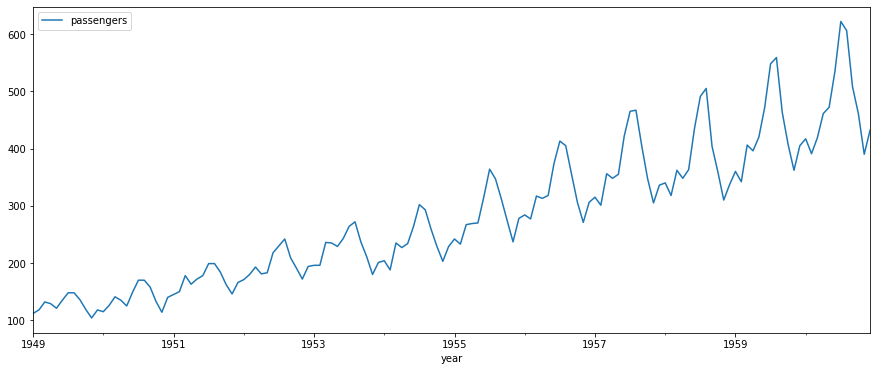

In [14]:
y.plot(figsize=(15, 6))
plt.show()

__Revisar gráficos de la densidad de observaciones puede proporcionar una mayor comprensión de la estructura de los datos:__
- La distribución no es perfectamente gaussiana (distribución normal).
- La distribución se desplaza a la izquierda.
- Las transformaciones pueden resultar útiles antes del modelado.

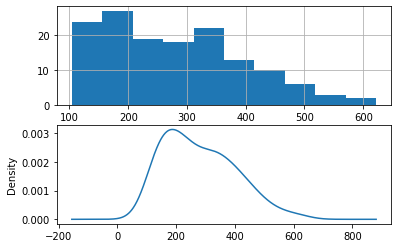

In [15]:
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
y.passengers.hist()
pyplot.subplot(212)
y.passengers.plot(kind='kde')
pyplot.show()

__Gráficos de caja y bigotes:__
- Los valores medios a lo largo de los años confirman una tendencia al alza
- Aumento constante del aumento
- Un modelo que considere la estacionalidad podría funcionar bien

<AxesSubplot:xlabel='year', ylabel='passengers'>

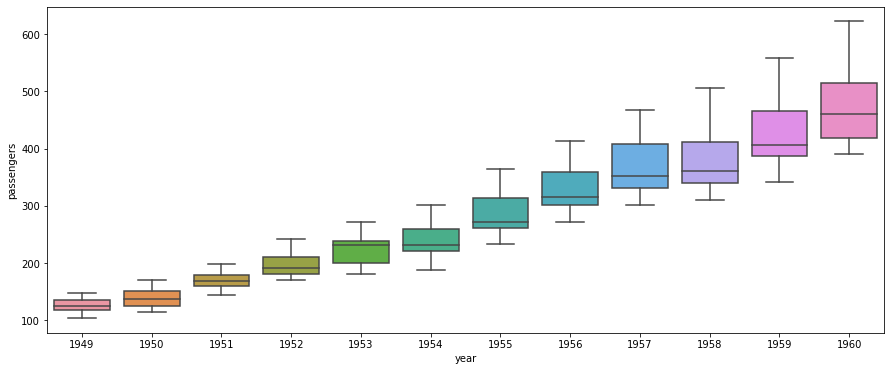

In [16]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(y.passengers.index.year, y.passengers, ax=ax)

__Descomposición usando statsmodel:__
- Podemos utilizar modelos de estadísticas para realizar una descomposición de esta serie temporal.
- La descomposición de series de tiempo es una tarea estadística que deconstruye una serie de tiempo en varios componentes, cada uno de los cuales representa una de las categorías subyacentes de patrones.
- Con los modelos de estadísticas podremos ver los componentes de tendencia, estacionales y residuales de nuestros datos.

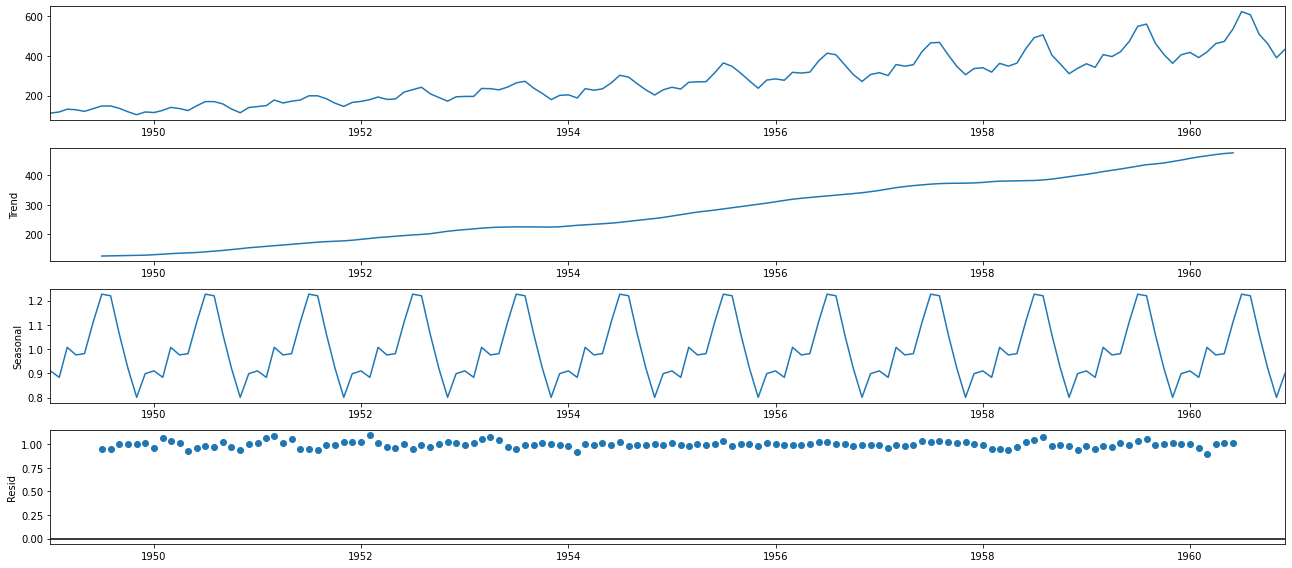

In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition.plot()
plt.show()

## Estacionariedad
- Se dice que una serie temporal es estacionaria si sus propiedades estadísticas, como la media y la varianza, permanecen constantes en el tiempo.
- La mayoría de los modelos de series temporales funcionan asumiendo que el TS es estacionario. La razón principal de esto es que hay muchas formas en que una serie puede ser no estacionaria, pero solo una forma de estacionariedad.
- Intuitivamente, podemos decir que si una Serie de Tiempo tiene un comportamiento particular a lo largo del tiempo, existe una probabilidad muy alta de que siga el mismo en el futuro.
- Además, las teorías relacionadas con las series estacionarias son más maduras y más fáciles de implementar en comparación con las series no estacionarias.

In [18]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()


    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

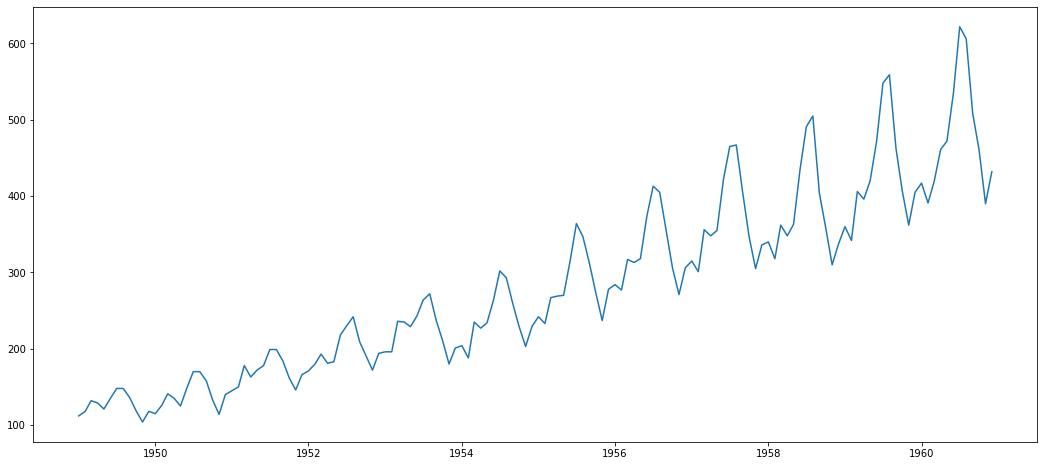

In [19]:
plt.plot(y)

__Podemos verificar la estacionariedad usando lo siguiente:__

- __Gráficos ACF y PACF__: si la serie de tiempo es estacionaria, los gráficos ACF / PACF mostrarán una __disminución rápida en la correlación__después de una pequeña cantidad de retraso entre los puntos.
- __Proporcionar estadísticas móviles__: podemos trazar la media móvil o la varianza móvil y ver si varía con el tiempo. La media móvil / varianza es para cualquier instante "t", la media / varianza del último año, es decir, los últimos 12 meses.
- __Prueba Dickey-Fuller aumentada:__ Esta es una de las pruebas estadísticas para comprobar la estacionariedad. Aquí la hipótesis nula es que el TS no es estacionario. Los resultados de la prueba comprenden una estadística de prueba y algunos valores críticos para los niveles de confianza de diferencia. Si la "estadística de prueba" es menor que el "valor crítico", podemos rechazar la hipótesis nula y decir que la serie es estacionaria

### Gráficos ACF y PACF

- Repasemos los gráficos de la función de autocorrelación (ACF) y la función de autocorrelación parcial (PACF)
- Si la serie de tiempo es estacionaria, las gráficas ACF / PACF mostrarán una __rápida caída en la correlación__ después de una pequeña cantidad de retraso entre los puntos.
- Estos datos no son estacionarios ya que un gran número de observaciones previas se correlacionan con valores futuros.
- Los intervalos de confianza se dibujan como un cono.
- De forma predeterminada, se establece en un intervalo de confianza del 95%, lo que sugiere que los valores de correlación fuera de este código son muy probablemente una correlación y no una casualidad estadística.
- La autocorrelación parcial  es la correlación que resulta después de eliminar el efecto de cualquier correlación debido a los términos en rezagos más cortos.

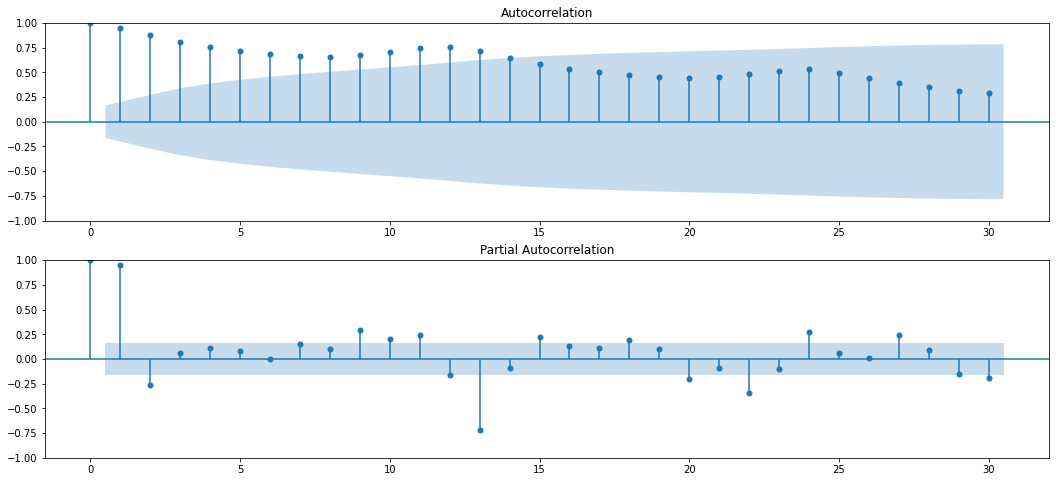

In [20]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(y.passengers, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(y.passengers, ax=pyplot.gca(), lags = 30)
pyplot.show()

### Estadísticas continuas
- Observamos que la media móvil y la desviación estándar no son constantes con respecto al tiempo (tendencia creciente)
- Por tanto, la serie temporal no es estacionaria

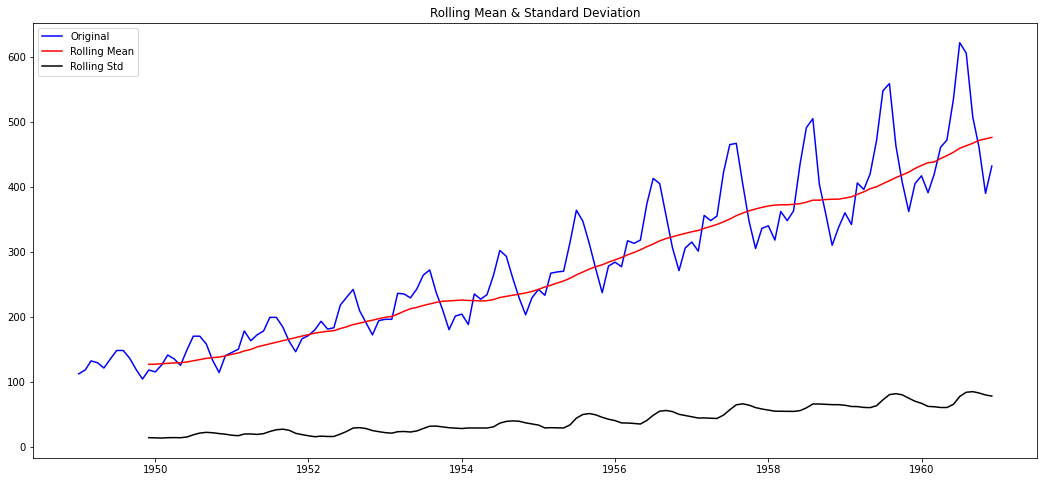

In [21]:
#Determing rolling statistics
rolmean = y.rolling(12).mean()
rolstd = y.rolling(12).std()

#Plot rolling statistics:
orig = plt.plot(y, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)


### Prueba Dickey-Fuller 

- Hipótesis nula: la serie temporal no es estacionaria
- Rechazar la hipótesis nula (es decir, un valor p muy bajo) indicará estacionaridad

In [22]:
from statsmodels.tsa.stattools import adfuller

In [23]:
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(y.passengers, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


## Hacer que las series temporales sean estacionarias
Hay 2 razones principales detrás de la no estacionariedad de un TS:

1. __Tendencia__ - media variable con el tiempo. Por ejemplo, en este caso vimos que, en promedio, el número de pasajeros estaba creciendo con el tiempo.
2. __Estacionalidad__: variaciones en períodos de tiempo específicos. por ejemplo, las personas pueden tener una tendencia a comprar automóviles en un mes en particular debido a incrementos salariales o festivales.

### Transformaciones
- Podemos aplicar transformaciones que penalicen más a los valores más altos que a los más pequeños. Estos pueden tomar un registro, una raíz cuadrada, una raíz cúbica, etc. Tomemos aquí una transformación de registro para simplificar:

#### Log Scale Transformation

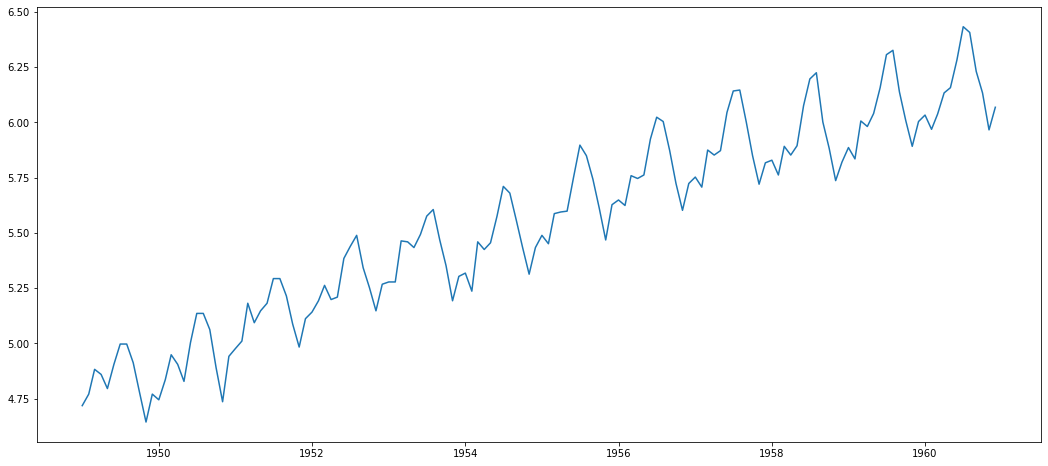

In [24]:
ts_log = np.log(y)
plt.plot(ts_log)

#### Otras posibles transformaciones:
- Transformación exponencial
- Transformación de Box Cox
- Transformación de raíz cuadrada

### Técnicas para eliminar Tendencia - Suavizado
- Suavizar es tomar promedios móviles en ventanas de tiempo

#### Media móvil
- Tomamos un promedio de "k" valores consecutivos dependiendo de la frecuencia de las series de tiempo.
- Aquí podemos tomar el promedio del último año, es decir, los últimos 12 valores.
- Un inconveniente de este enfoque particular es que el período de tiempo debe definirse estrictamente.

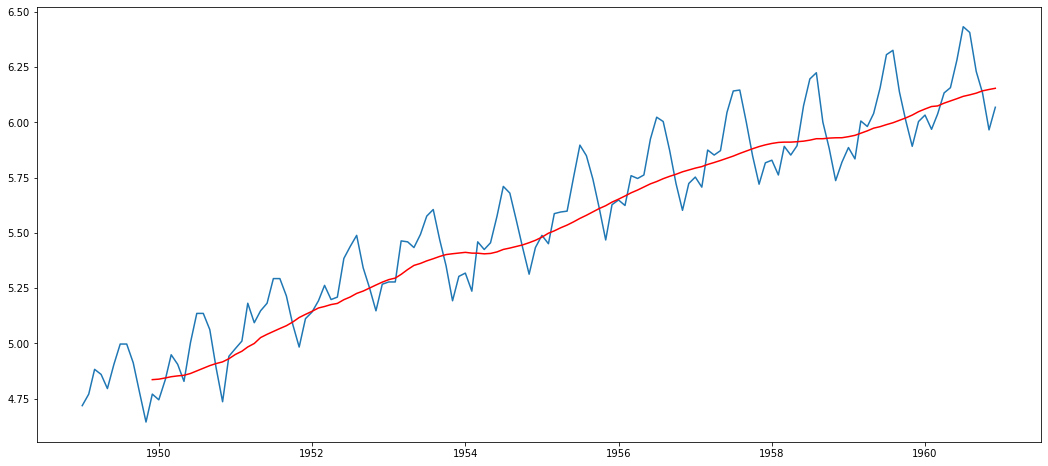

In [25]:
moving_avg = ts_log.rolling(12).mean()

plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [26]:
ts_log_moving_avg_diff = ts_log.passengers - moving_avg.passengers
ts_log_moving_avg_diff.head(12)

year
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: passengers, dtype: float64

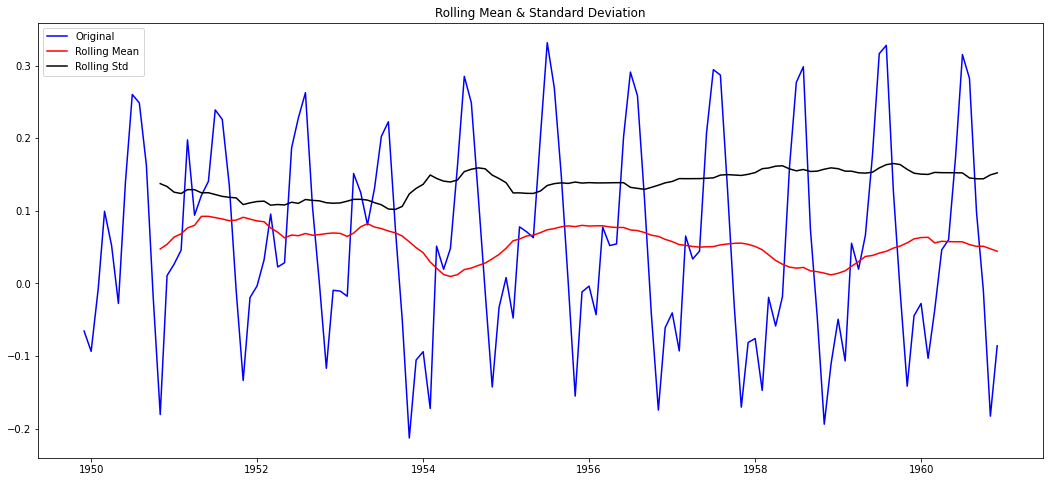

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [27]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

#### Media móvil ponderada exponencialmente:
- Para superar el problema de elegir una ventana definida en la media móvil, podemos utilizar la media móvil ponderada exponencial
- Tomamos un "promedio móvil ponderado" donde los valores más recientes reciben un peso más alto.
- Puede haber muchas técnicas para asignar pesos. Uno popular es el promedio móvil ponderado exponencialmente donde se asignan pesos a todos los valores anteriores con un factor de disminución.

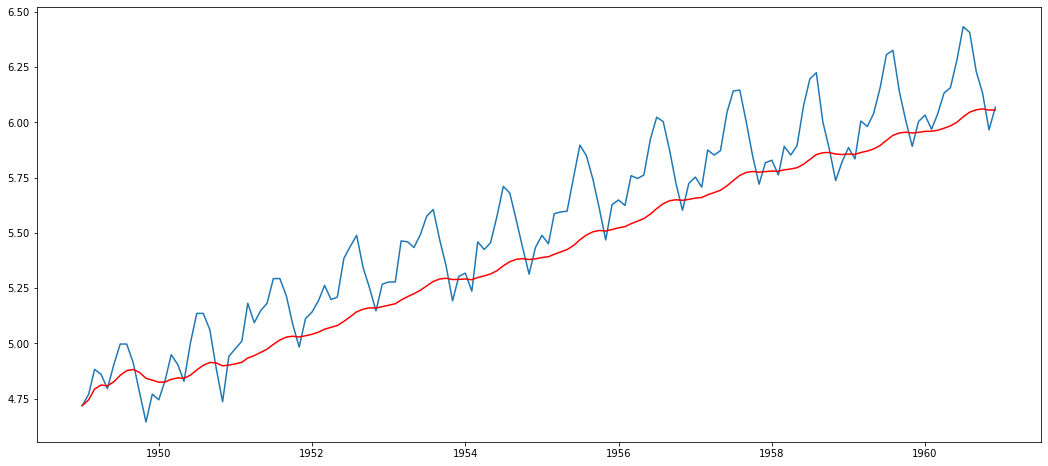

In [28]:
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

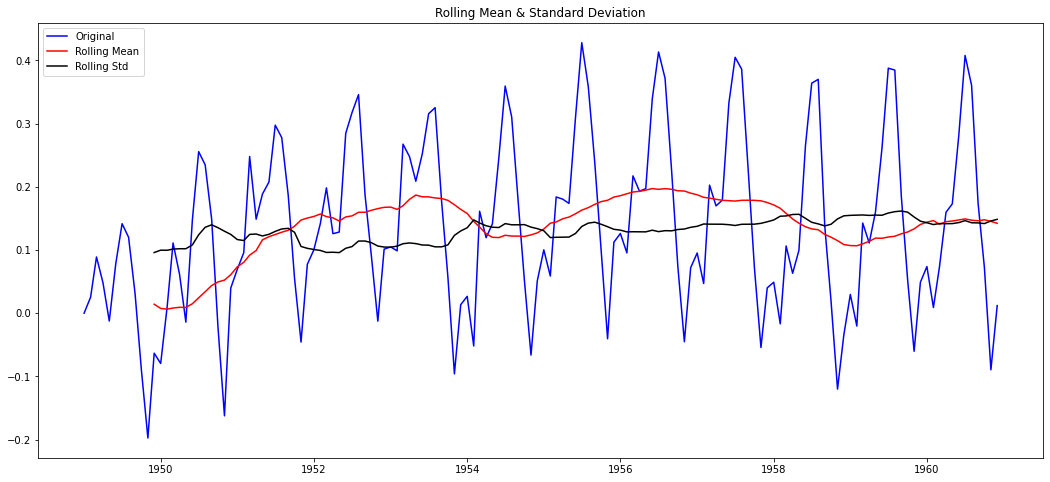

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [29]:
ts_log_ewma_diff = ts_log.passengers - expwighted_avg.passengers
test_stationarity(ts_log_ewma_diff)

### Más técnicas para eliminar la estacionalidad y la tendencia
- Las técnicas simples de reducción de tendencias discutidas antes no funcionan en todos los casos, particularmente en los que tienen una alta estacionalidad.

#### Diferenciación
- En esta técnica, tomamos la diferencia de la observación en un instante particular con la del instante anterior.


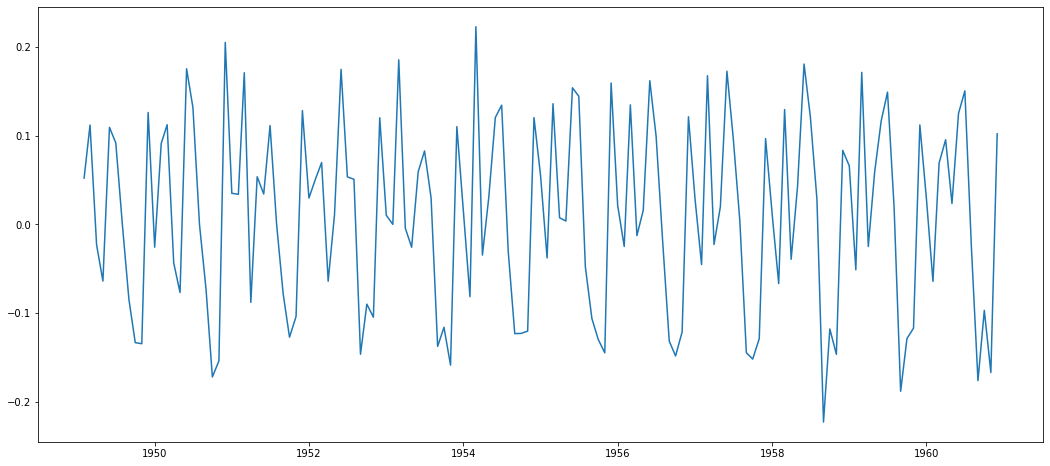

In [30]:
ts_log_diff = ts_log.passengers - ts_log.passengers.shift()
plt.plot(ts_log_diff)

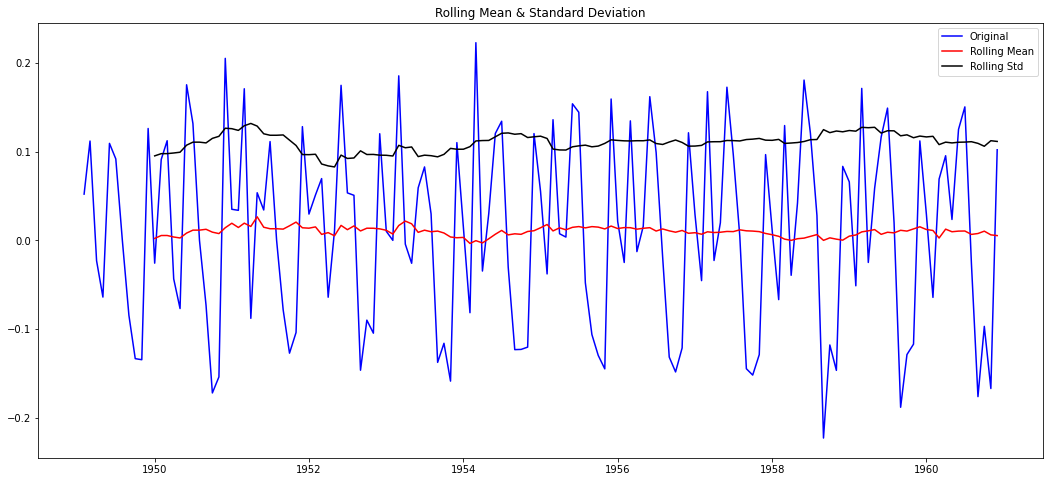

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [31]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

#### Descomposición
- En este enfoque, tanto la tendencia como la estacionalidad se modelan por separado y se devuelve la parte restante de la serie.

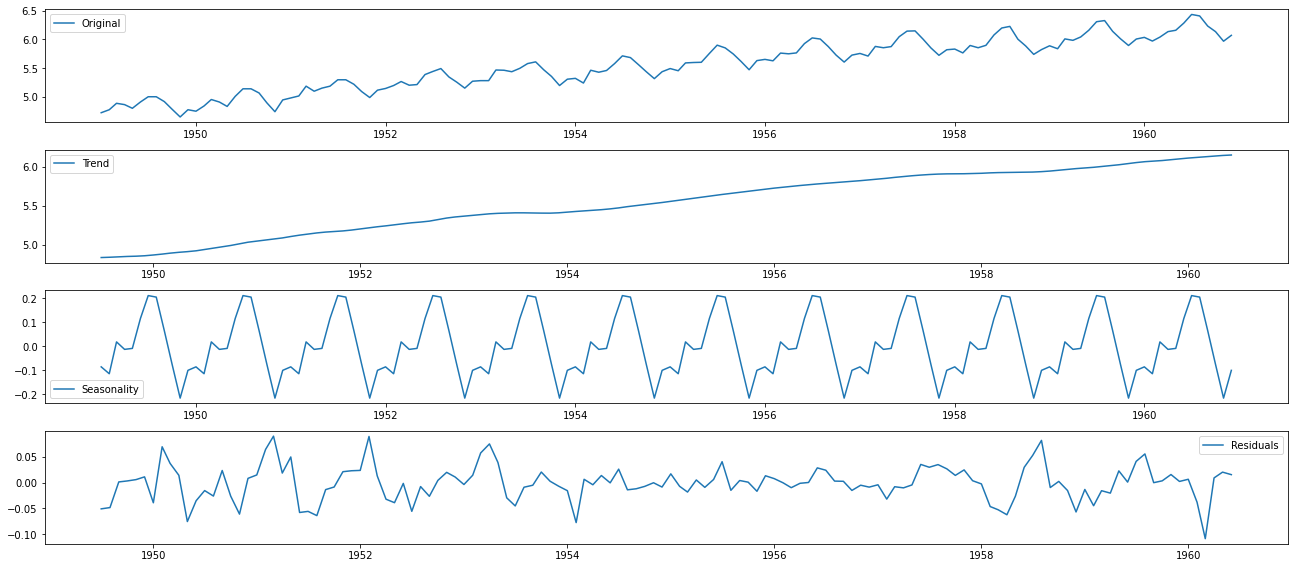

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Predicción de Series Temporales


## Autoregresión (AR)
- El método de autorregresión (AR) modela el siguiente paso de la secuencia como una función lineal de las observaciones en los pasos de tiempo anteriores.
- __Número de términos AR (autorregresivos) (p):__ p es el parámetro asociado con el aspecto autorregresivo del modelo, que incorpora valores pasados, es decir, rezagos de la variable dependiente. Por ejemplo, si p es 5, los predictores de x (t) serán x (t-1)… .x (t-5).

In [33]:
from statsmodels.tsa.ar_model import AR
from random import random

In [34]:
# fit model
model = AR(ts_log_diff)
model_fit = model.fit()

NotImplementedError: AR has been removed from statsmodels and replaced with statsmodels.tsa.ar_model.AutoReg.

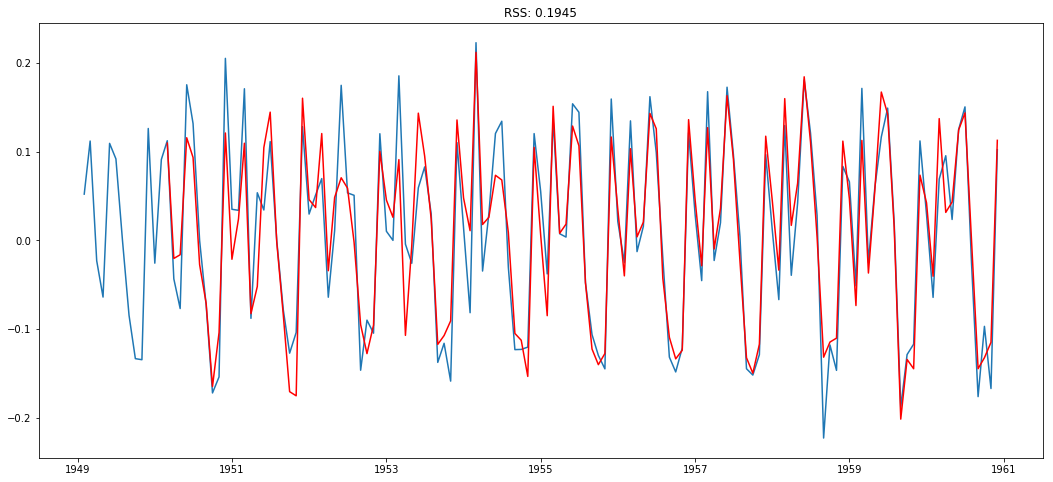

In [ ]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))
plt.show()

### Invertir las transformaciones

__Valores ajustados o predichos:__

In [ ]:
predictions_ARIMA_diff = pd.Series(model_fit.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

year
1950-03-01    0.109713
1950-04-01   -0.020423
1950-05-01   -0.016243
1950-06-01    0.115842
1950-07-01    0.093564
dtype: float64


__Suma acumulativa para invertir la diferenciación:__

In [ ]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

year
1950-03-01    0.109713
1950-04-01    0.089291
1950-05-01    0.073048
1950-06-01    0.188891
1950-07-01    0.282455
dtype: float64


__Añadir el valor del primer mes que se eliminó anteriormente al diferenciar:__

In [ ]:
predictions_ARIMA_log = pd.Series(ts_log.passengers.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

year
1949-01-01    4.718499
1949-02-01    4.718499
1949-03-01    4.718499
1949-04-01    4.718499
1949-05-01    4.718499
dtype: float64

__Tomando exponente para invertir la transformación logarítmica:__

In [ ]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)

Text(0.5,1,'RMSE: 78.5144')

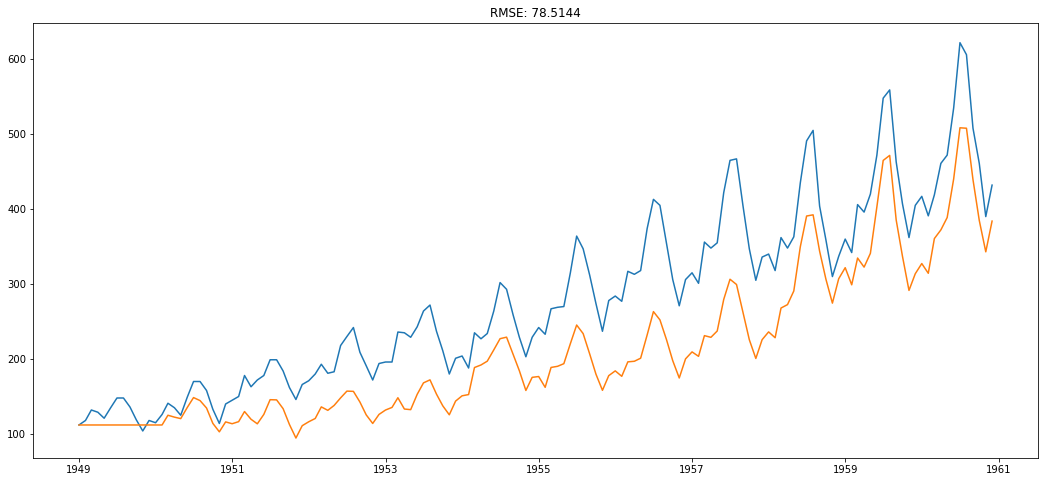

In [ ]:
plt.plot(y.passengers)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA-y.passengers)**2)/len(y.passengers)))

### Métricas de puntuación de la calidad del pronóstico
- __R-cuadrado__
- __Mean Absolute Error__
- __Error absoluto medio__
- __Error medio cuadrado__
- __Error logarítmico al cuadrado medio__
- __Error de porcentaje absoluto medio__

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

__R squared__, coefficient of determination (it can be interpreted as a percentage of variance explained by the model), (-inf, 1] 
- sklearn.metrics.r2_score

In [ ]:
r2_score(y.passengers, predictions_ARIMA)

0.5686734896130747

__Mean Absolute Error__, it is an interpretable metric because it has the same unit of measurement as the initial series, [0, +inf)
- sklearn.metrics.mean_absolute_error

In [ ]:
mean_absolute_error(y.passengers, predictions_ARIMA)

69.42862838872742

__Median Absolute Error__, again an interpretable metric, particularly interesting because it is robust to outliers, [0, +inf)
- sklearn.metrics.median_absolute_error

In [ ]:
median_absolute_error(y.passengers, predictions_ARIMA)

69.3669543538475

__Mean Squared Error__, most commonly used, gives higher penalty to big mistakes and vise versa, [0, +inf)
- sklearn.metrics.mean_squared_error


In [ ]:
mean_squared_error(y.passengers, predictions_ARIMA)

6164.506983577624

__Mean Squared Logarithmic Error__, practically the same as MSE but we initially take logarithm of the series, as a result we give attention to small mistakes as well, usually is used when data has exponential trends, [0, +inf)
- sklearn.metrics.mean_squared_log_error

In [ ]:
mean_squared_log_error(y.passengers, predictions_ARIMA)

0.09945599448249746

__Mean Absolute Percentage Error__, same as MAE but percentage, — very convenient when you want to explain the quality of the model to your management, [0, +inf), 
- not implemented in sklearn

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_percentage_error(y.passengers, predictions_ARIMA)

24.472405429862327

__Function to evaluate forecast using above metrics:__

In [ ]:
def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [ ]:
evaluate_forecast(y.passengers, predictions_ARIMA)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.568673,69.428628,69.366954,6164.506984,0.099456,24.472405,78.514374


- RMSE tiene la ventaja de penalizar más los errores grandes, por lo que puede ser más apropiado en algunos casos, por ejemplo, si estar fuera de 10 es más del doble de malo que estar fuera de 5. Pero si estar fuera de 10 es solo el doble de malo. como si fuera de 5, entonces MAE es más apropiado.

- Desde el punto de vista de la interpretación, MAE es claramente el ganador. RMSE no describe el error promedio solo y tiene otras implicaciones que son más difíciles de descifrar y comprender.

- Por otro lado, una clara ventaja de RMSE sobre MAE es que RMSE evita el uso de tomar el valor absoluto, lo cual no es deseable en muchos cálculos matemáticos.

## Media móvil (MA)

- __Número de términos MA (media móvil) (q):__ q es el tamaño de la ventana parcial de media móvil del modelo, es decir, errores de pronóstico retrasados en la ecuación de predicción. Por ejemplo, si q es 5, los predictores para x (t) serán e (t-1)… .e (t-5) donde e (i) es la diferencia entre la media móvil en iésimo instante y el valor real.

In [ ]:
# MA example
from statsmodels.tsa.arima_model import ARMA
from random import random

# fit model
model = ARMA(ts_log_diff, order=(0, 1))
model_fit = model.fit(disp=False)

In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             passengers   No. Observations:                  143
Model:                     ARMA(0, 1)   Log Likelihood                 121.754
Method:                       css-mle   S.D. of innovations              0.103
Date:                Mon, 23 Aug 2021   AIC                           -237.507
Time:                        10:32:13   BIC                           -228.619
Sample:                    02-01-1949   HQIC                          -233.895
                         - 12-01-1960                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0097      0.011      0.887      0.375      -0.012       0.031
ma.L1.passengers     0.2722      0.095      2.873      0.004       0.086       0.458
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -3.6744           +0.0000j            3.6744            0.5000
-----------------------------------------------------------------------------
"""

Text(0.5,1,'RSS: 1.5245')

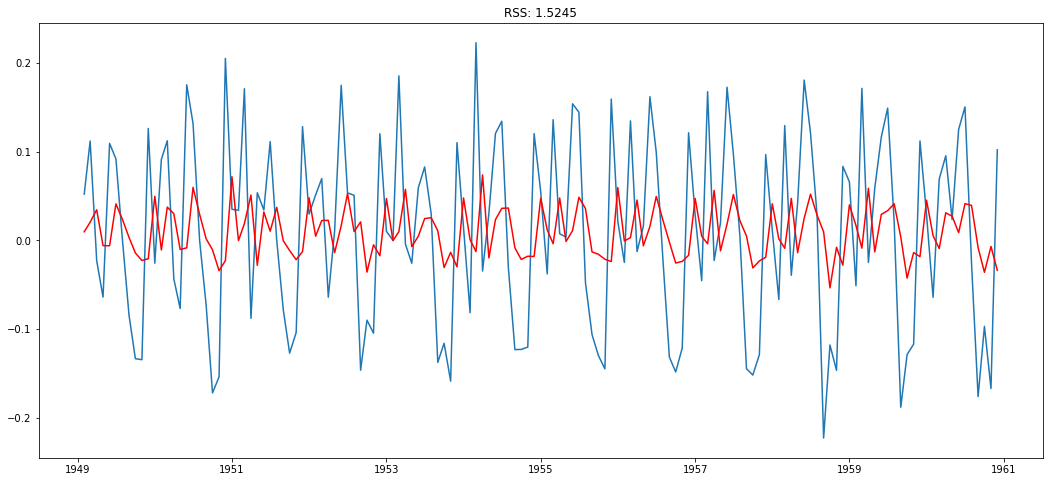

In [ ]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))

## Media móvil autorregresiva (ARMA)

- __Número de términos AR (autorregresivos) (p):__ p es el parámetro asociado con el aspecto autorregresivo del modelo, que incorpora valores pasados, es decir, rezagos de la variable dependiente. Por ejemplo, si p es 5, los predictores de x (t) serán x (t-1)… .x (t-5).
- __Número de términos MA (media móvil) (q):__ q es el tamaño de la ventana parcial de media móvil del modelo, es decir, errores de pronóstico retrasados en la ecuación de predicción. Por ejemplo, si q es 5, los predictores para x (t) serán e (t-1)… .e (t-5) donde e (i) es la diferencia entre la media móvil en iésimo instante y el valor real.

In [ ]:
# ARMA example
from statsmodels.tsa.arima_model import ARMA
from random import random

# fit model
model = ARMA(ts_log_diff, order=(2, 1))
model_fit = model.fit(disp=False)

In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             passengers   No. Observations:                  143
Model:                     ARMA(2, 1)   Log Likelihood                 140.076
Method:                       css-mle   S.D. of innovations              0.090
Date:                Mon, 23 Aug 2021   AIC                           -270.151
Time:                        10:32:14   BIC                           -255.337
Sample:                    02-01-1949   HQIC                          -264.131
                         - 12-01-1960                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0101      0.000     23.509      0.000       0.009       0.011
ar.L1.passengers     0.9982      0.076     13.162      0.000       0.850       1.147
ar.L2.passengers    -0.4134      0.077     -5.384      0.000      -0.564      -0.263
ma.L1.passengers    -0.9999      0.028    -35.273      0.000      -1.056      -0.944
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2073           -0.9805j            1.5553           -0.1086
AR.2            1.2073           +0.9805j            1.5553            0.1086
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

Text(0.5,1,'RSS: 1.1753')

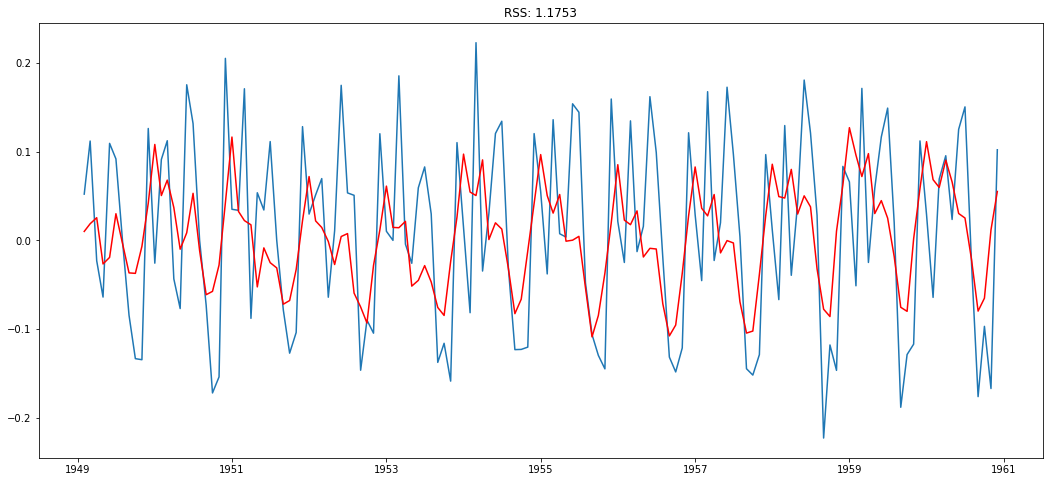

In [ ]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))

## Media móvil integrada autorregresiva (ARIMA)
En un modelo ARIMA hay 3 parámetros que se utilizan para ayudar a modelar los aspectos principales de una serie de tiempo: estacionalidad, tendencia y ruido. Estos parámetros se denominan p, d y q.

- __Número de términos AR (Auto-Regresivos) (p):__ p es el parámetro asociado con el aspecto auto-regresivo del modelo, que incorpora valores pasados, es decir, rezagos de la variable dependiente. Por ejemplo, si p es 5, los predictores de x (t) serán x (t-1)… .x (t-5).
- __Número de diferencias (d):__ d es el parámetro asociado con la parte integrada del modelo, que afecta la cantidad de diferenciación a aplicar a una serie de tiempo.
- __Número de términos MA (media móvil) (q):__ q es el tamaño de la ventana parcial de media móvil del modelo, es decir, errores de pronóstico retrasados ​​en la ecuación de predicción. Por ejemplo, si q es 5, los predictores para x (t) serán e (t-1)… .e (t-5) donde e (i) es la diferencia entre la media móvil en iésimo instante y el valor real.

<br> __Observaciones de EDA sobre la serie temporal:__
- La no estacionariedad implica que se requiere al menos un nivel de diferenciación (d) en ARIMA
- El siguiente paso es seleccionar los valores de retardo para los parámetros Autoregresión (AR) y Media móvil (MA), pyq respectivamente, usando gráficos PACF, ACF

Nota: Un problema con ARIMA es que no admite datos estacionales. Esa es una serie de tiempo con un ciclo que se repite. ARIMA espera datos que no sean estacionales o que tengan el componente estacional eliminado, p. Ej. ajustado estacionalmente mediante métodos como la diferenciación estacional.

In [ ]:
ts = y.passengers - y.passengers.shift()
ts.dropna(inplace=True)

__Gráficos de ACF y PACF después de la diferenciación:__
- Los intervalos de confianza se dibujan como un cono.
- De forma predeterminada, se establece en un intervalo de confianza del 95%, lo que sugiere que los valores de correlación fuera de este código son muy probablemente una correlación y no una casualidad estadística.
- Proceso AR (1) - tiene ACF colapsando y PACF cortando en lag = 1
- Proceso AR (2) - tiene ACF colapsando y PACF cortando en lag = 2
- Proceso MA (1) - tiene ACF cortado en lag = 1
- Proceso MA (2) - tiene ACF cortado en lag = 2

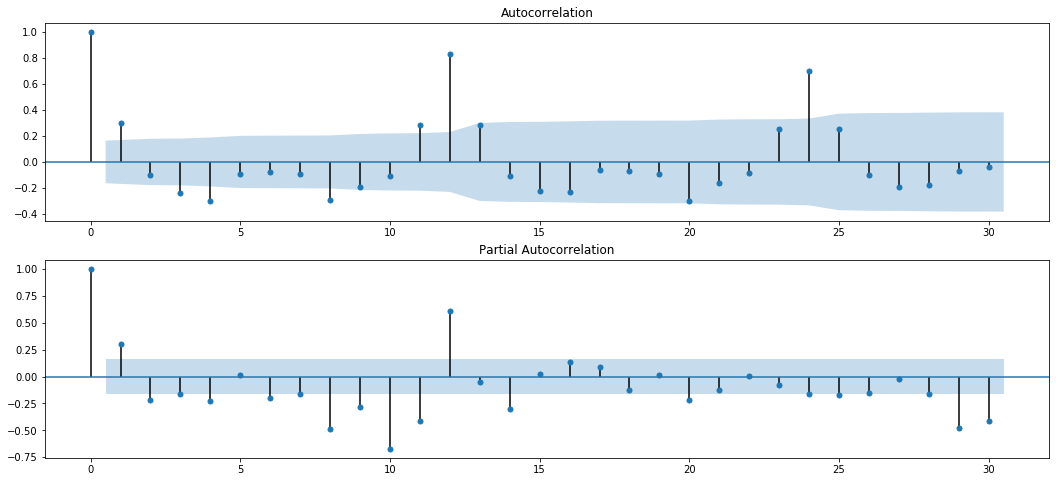

In [ ]:
pyplot.figure()
pyplot.subplot(211)
plot_acf(ts, ax=pyplot.gca(),lags=30)
pyplot.subplot(212)
plot_pacf(ts, ax=pyplot.gca(),lags=30)
pyplot.show()

## Interpretación de gráficos ACF


ACF Shape	| Indicated Model |
-- | -- |
Exponential, decaying to zero |	Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model |
Alternating positive and negative, decaying to zero	Autoregressive model. |  Use the partial autocorrelation plot to help identify the order. |
One or more spikes, rest are essentially zero | Moving average model, order identified by where plot becomes zero. |
Decay, starting after a few lags |	Mixed autoregressive and moving average (ARMA) model. | 
All zero or close to zero | Data are essentially random. |
High values at fixed intervals | Include seasonal autoregressive term. |
No decay to zero |	Series is not stationary |

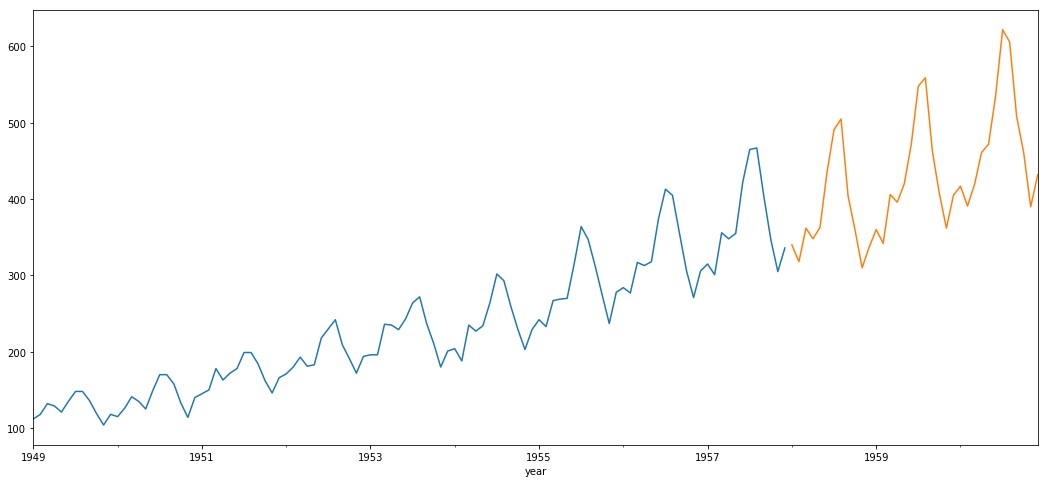

In [ ]:
#divide into train and validation set
train = y[:int(0.75*(len(y)))]
valid = y[int(0.75*(len(y))):]

#plotting the data
train['passengers'].plot()
valid['passengers'].plot()

In [ ]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# fit model
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit(disp=1)

In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.passengers   No. Observations:                  107
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -493.230
Method:                       css-mle   S.D. of innovations             23.986
Date:                Mon, 23 Aug 2021   AIC                            994.461
Time:                        10:32:15   BIC                           1005.152
Sample:                    02-01-1949   HQIC                           998.795
                         - 12-01-1957                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.4356      0.265      9.186      0.000       1.916       2.955
ar.L1.D.passengers     0.7409      0.067     10.991      0.000       0.609       0.873
ma.L1.D.passengers    -1.0000      0.025    -39.435      0.000      -1.050      -0.950
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3496           +0.0000j            1.3496            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)

In [ ]:
# report performance
mse = mean_squared_error(y[start_index:end_index], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 432.626379752622, MSE:187165.5844578599


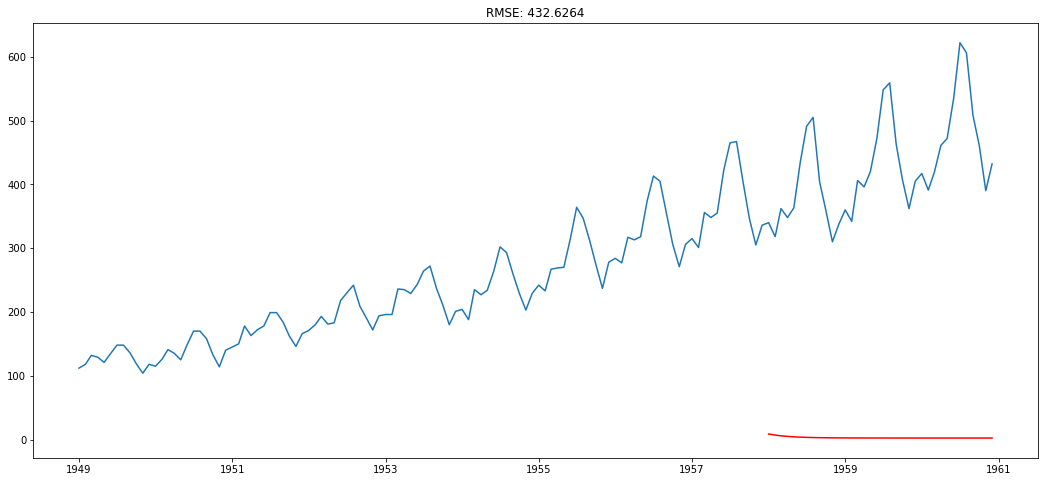

In [ ]:
plt.plot(y.passengers)
plt.plot(predictions, color='red')
plt.title('RMSE: %.4f'% rmse)
plt.show()

__Valores ajustados o predichos:__

In [ ]:
predictions_ARIMA_diff = pd.Series(predictions, copy=True)
print (predictions_ARIMA_diff.head())

1958-01-01    8.743426
1958-02-01    7.109321
1958-03-01    5.898544
1958-04-01    5.001429
1958-05-01    4.336719
Freq: MS, dtype: float64


__Suma acumulativa para invertir la diferenciación:__

In [ ]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

1958-01-01     8.743426
1958-02-01    15.852747
1958-03-01    21.751292
1958-04-01    26.752721
1958-05-01    31.089440
Freq: MS, dtype: float64


__Añadir el valor del primer mes que se eliminó anteriormente al diferenciar:__

In [ ]:
predictions_ARIMA_log = pd.Series(valid.passengers.iloc[0], index=valid.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

year
1958-01-01    348.743426
1958-02-01    355.852747
1958-03-01    361.751292
1958-04-01    366.752721
1958-05-01    371.089440
dtype: float64

__Tomando exponente para invertir la transformación logarítmica:__

Text(0.5,1,'RMSE: 205.2935')

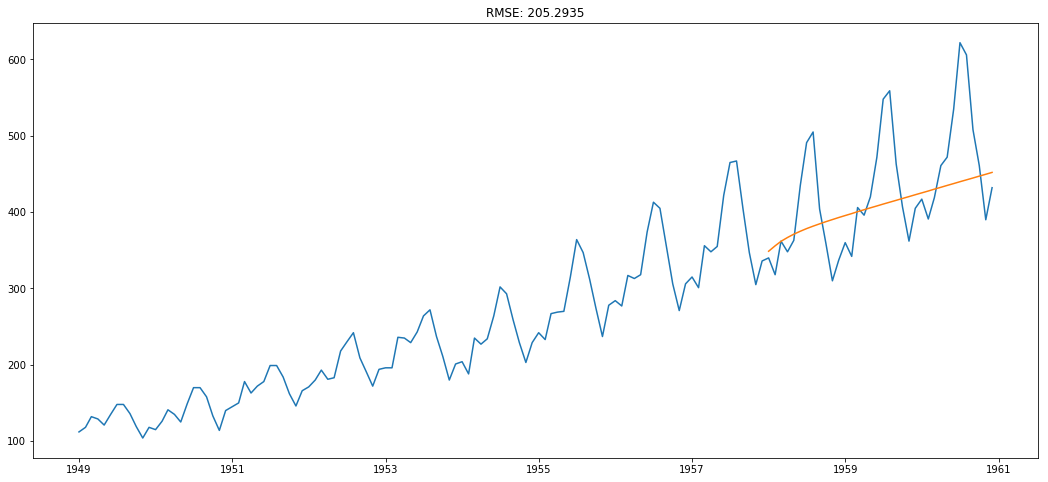

In [ ]:
plt.plot(y.passengers)
plt.plot(predictions_ARIMA_log)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA_log-ts)**2)/len(ts)))

In [ ]:
evaluate_forecast(y[start_index:end_index], predictions_ARIMA_log)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.179865,52.106955,36.843691,5017.836392,0.023691,NaN,70.836688


### Auto ARIMA

In [ ]:
#building the model
#from pyramid.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=959.218, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1002.826, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=996.373, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=991.646, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1001.531, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=988.670, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=983.832, Time=0.07 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 2.404 seco

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

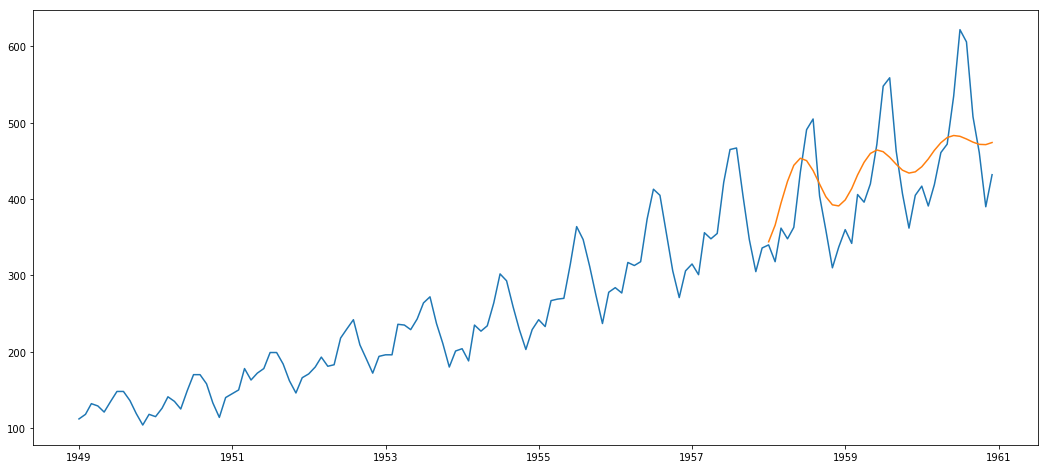

In [ ]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(y.passengers, label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [ ]:
evaluate_forecast(valid, forecast)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.427068,49.488311,43.100292,3505.372356,0.017613,NaN,59.206185


## Promedio móvil integrado autorregresivo estacional (SARIMA)
El promedio móvil integrado autorregresivo estacional, SARIMA o ARIMA estacional, es una extensión de ARIMA que admite explícitamente datos de series de tiempo univariantes con un componente estacional.

Agrega tres nuevos hiperparámetros para especificar la autorregresión (AR), la diferenciación (I) y la media móvil (MA) para el componente estacional de la serie, así como un parámetro adicional para el período de la estacionalidad.

__Elementos de tendencia:__

Hay tres elementos de tendencia que requieren configuración. Son los mismos que el modelo ARIMA, concretamente:

- p: orden de autorregresión de tendencia.
- d: orden de diferencia de tendencia.
- q: Orden de media móvil de tendencia.

__Elementos de temporada:__

Hay cuatro elementos estacionales que no forman parte de ARIMA que deben configurarse; son:

- P: orden autorregresivo estacional.
- D: orden de diferencia estacional.
- Q: Orden de media móvil estacional.
- m: el número de pasos de tiempo para un solo período estacional. Por ejemplo, una S de 12 para datos mensuales sugiere un ciclo estacional anual.

__Notación Sarima:__
SARIMA (p, d, q) (P, D, Q, m)

In [ ]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX

# fit model
model = SARIMAX(train, order=(3, 1, 3), seasonal_order=(1, 1, 1, 4))
model_fit = model.fit(disp=False)

In [ ]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)

In [ ]:
# report performance
mse = mean_squared_error(y[start_index:end_index], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 63.9933755285855, MSE:4095.152111542566


Text(0.5,1,'RMSE: 63.9934')

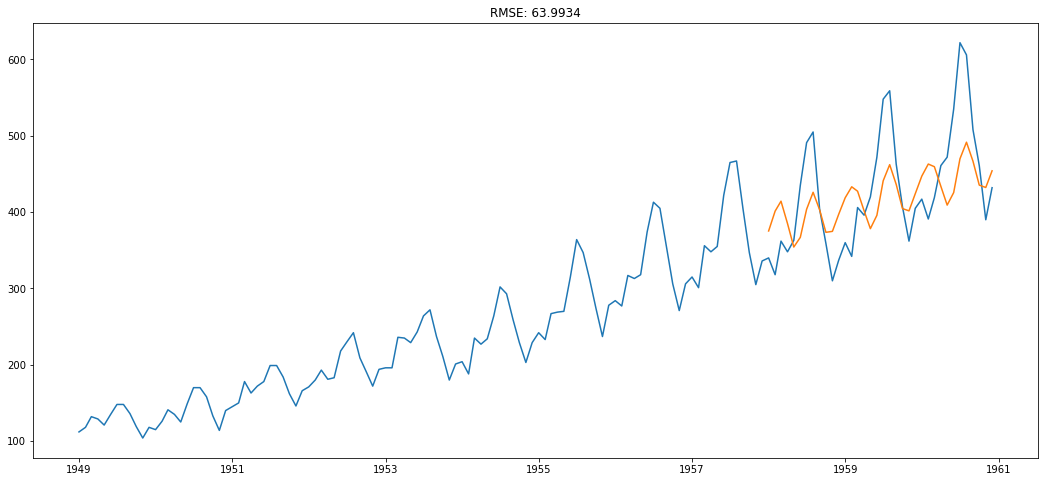

In [ ]:
plt.plot(y)
plt.plot(predictions)
plt.title('RMSE: %.4f'% rmse)

In [ ]:
evaluate_forecast(y[start_index:end_index], predictions)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.330672,53.279299,41.963103,4095.152112,0.0205,NaN,63.993376


### Auto - SARIMA

[auto_arima documentation for selecting best model](https://www.alkaline-ml.com/pmdarima/tips_and_tricks.html)

In [ ]:
#building the model
#from pyramid.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', 
                   suppress_warnings=True, seasonal=True, m=6, stepwise=True)
model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=936.762, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=1002.826, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=997.166, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=993.576, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=1001.531, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[6] intercept   : AIC=956.753, Time=0.44 sec
 ARIMA(2,1,2)(1,0,0)[6] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(2,1,2)(2,0,1)[6] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(2,1,2)(1,0,2)[6] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(2,1,2)(0,0,0)[6] intercept   : AIC=959.218, Time=0.23 sec
 ARIMA(2,1,2)(0,0,2)[6] intercept   : AIC=907.754, Time=0.59 sec
 ARIMA(1,1,2)(0,0,2)[6] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(2,1,1)(0,0,2)[6] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(3,1,2)(0,0,2)[6] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(2,1,3)(0,0,2)[6] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(1

ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(0, 0, 2, 6),
      suppress_warnings=True)

In [ ]:
pred = model.predict(n_periods=len(valid))
pred = pd.DataFrame(pred,index = valid.index,columns=['Prediction'])

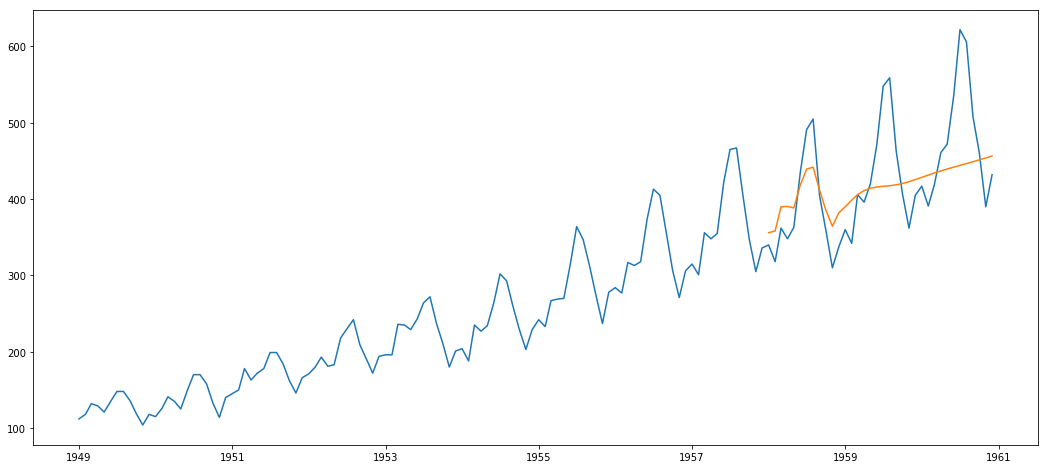

In [ ]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(y.passengers, label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [ ]:
evaluate_forecast(y[start_index:end_index], forecast)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.335602,47.312468,36.378719,4064.992993,0.01848,NaN,63.757298


### Tuned SARIMA

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 6)
SARIMAX: (0, 0, 1) x (0, 1, 0, 6)
SARIMAX: (0, 1, 0) x (0, 1, 1, 6)
SARIMAX: (0, 1, 0) x (1, 0, 0, 6)


In [ ]:
min_aic = 999999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            #Check for best model with lowest AIC
            if results.aic < min_aic:
                min_aic = results.aic
                min_aic_model = results
        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 0, 6)12 - AIC:1484.6772209911371
ARIMA(0, 0, 0)x(0, 0, 1, 6)12 - AIC:1332.7081717070837
ARIMA(0, 0, 0)x(0, 1, 0, 6)12 - AIC:1106.9983169558561
ARIMA(0, 0, 0)x(0, 1, 1, 6)12 - AIC:1015.267707006776
ARIMA(0, 0, 0)x(1, 0, 0, 6)12 - AIC:1115.9461051704866
ARIMA(0, 0, 0)x(1, 0, 1, 6)12 - AIC:1001.4755946445588
ARIMA(0, 0, 0)x(1, 1, 0, 6)12 - AIC:951.0958895418038
ARIMA(0, 0, 0)x(1, 1, 1, 6)12 - AIC:860.2555893602381
ARIMA(0, 0, 1)x(0, 0, 0, 6)12 - AIC:1334.2309362006306
ARIMA(0, 0, 1)x(0, 0, 1, 6)12 - AIC:1194.125735711348
ARIMA(0, 0, 1)x(0, 1, 0, 6)12 - AIC:998.4912121256946
ARIMA(0, 0, 1)x(0, 1, 1, 6)12 - AIC:912.8780689458905
ARIMA(0, 0, 1)x(1, 0, 0, 6)12 - AIC:1018.973356922363
ARIMA(0, 0, 1)x(1, 0, 1, 6)12 - AIC:914.9884754558612
ARIMA(0, 0, 1)x(1, 1, 0, 6)12 - AIC:866.372739678231
ARIMA(0, 0, 1)x(1, 1, 1, 6)12 - AIC:792.5520247091866
ARIMA(0, 1, 0)x(0, 0, 0, 6)12 - AIC:993.1312724630138
ARIMA(0, 1, 0)x(0, 0, 1, 6)12 - AIC:943.9245123025298
ARIMA(0, 1, 0)x(0, 1, 0

In [ ]:
min_aic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        passengers   No. Observations:                  108
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 6)   Log Likelihood                -337.236
Date:                           Mon, 23 Aug 2021   AIC                            682.471
Time:                                   10:35:56   BIC                            692.602
Sample:                               01-01-1949   HQIC                           686.562
                                    - 12-01-1957                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4552      0.082     -5.543      0.000      -0.616      -0.294
ar.S.L6       -1.0894      0.017    -65.216      0.000      -1.122      -1.057
ma.S.L6        2.2737      0.600      3.791      0.000       1.098       3.449
sigma2        15.8260      7.949      1.991      0.046       0.247      31.405
===================================================================================
Ljung-Box (Q):                       45.44   Jarque-Bera (JB):                 2.17
Prob(Q):                              0.26   Prob(JB):                         0.34
Heteroskedasticity (H):               0.61   Skew:                             0.37
Prob(H) (two-sided):                  0.17   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
pred = min_aic_model.get_prediction(start=start_index,end=end_index, dynamic=False)

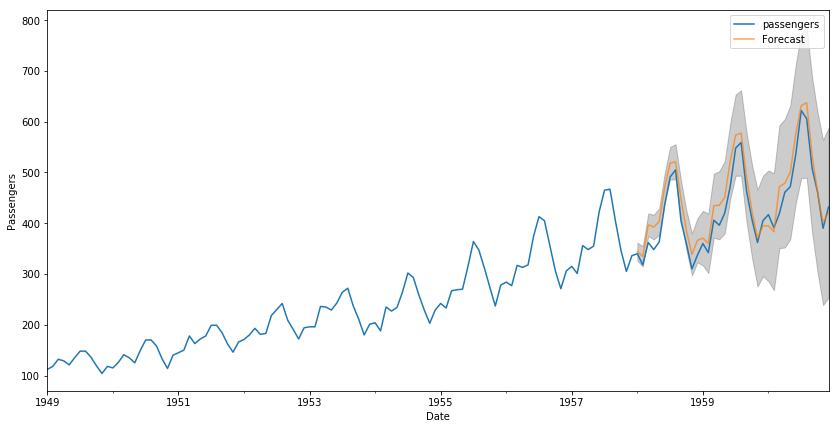

In [ ]:
pred_ci = pred.conf_int()
ax = y['1949':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()
plt.show()

__Modelo de diagnóstico:__
- Nuestra principal preocupación es asegurarnos de que los residuos de nuestro modelo no estén correlacionados y se distribuyan normalmente con una media cero.
- Si el modelo ARIMA estacional no satisface estas propiedades, es un buen indicio de que se puede mejorar aún más.

El diagnóstico del modelo sugiere que el residuo del modelo se distribuye normalmente según lo siguiente:

- En el gráfico superior derecho, la línea roja de KDE sigue de cerca a la línea N (0,1). Donde, N (0,1) es la notación estándar para una distribución normal con media 0 y desviación estándar de 1. Esta es una buena indicación de que los residuos están distribuidos normalmente.
- El gráfico qq en la parte inferior izquierda muestra que la distribución ordenada de los residuos (puntos azules) sigue la tendencia lineal de las muestras tomadas de una distribución normal estándar. Nuevamente, esta es una fuerte indicación de que los residuos se distribuyen normalmente.
- Los residuos a lo largo del tiempo (gráfico superior izquierdo) no muestran ninguna estacionalidad obvia y parecen ser ruido blanco.
- Esto se confirma con el gráfico de autocorrelación (es decir, correlograma) en la parte inferior derecha, que muestra que los residuos de la serie de tiempo tienen una baja correlación con las versiones retrasadas de sí mismo.

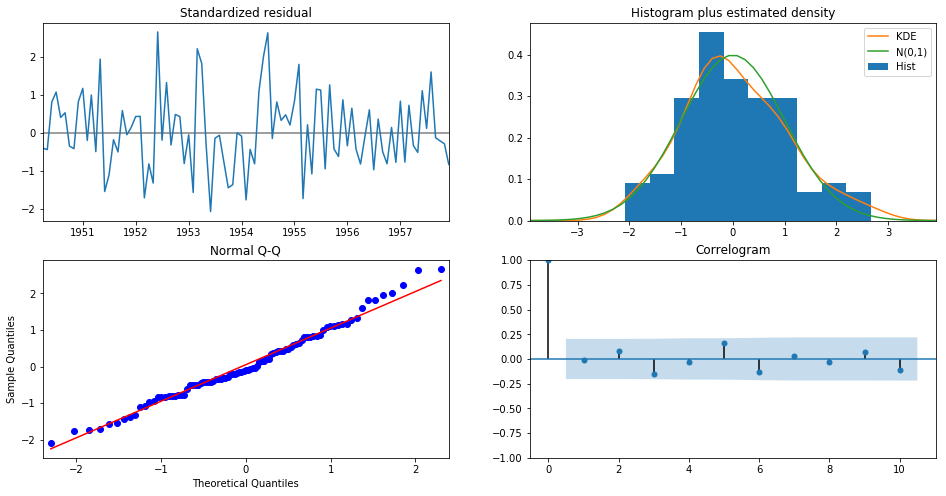

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean.values
y_truth = y[start_index:end_index].passengers.values
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 781.5


In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 27.96


In [ ]:
evaluate_forecast(y_truth, y_forecasted)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.872269,24.733282,26.185111,781.497469,0.004216,5.932265,27.955276


## SARIMAX
- La implementación se llama SARIMAX en lugar de SARIMA porque la adición "X" al nombre del método significa que la implementación también admite variables exógenas.
- Las variables exógenas son opcionales y se pueden especificar mediante el argumento "exog".
  - modelo = SARIMAX (datos, exog = otros_datos, ...)
- Ejemplos de variables exógenas: población, vacaciones, número de compañías aéreas, eventos importantes

## Mejora de los modelos de pronóstico de series de tiempo

1. Optimización de hiperparámetros: Encontrar los parámetros óptimos de los modelos ARIMA / Prophet.

2. Variables exógenas (SARIMAX): Incluyendo variables externas como campañas, vacaciones, eventos, calamidades naturales, etc.

3. Combinación de modelos para predicciones avanzadas de series de tiempo

4. Deep Learning. Red de memoria a corto plazo a largo plazo (LSTM)